In [1]:
using PyPlot, FileIO, AnomalyDetection, EvalCurves
import PyPlot: plot
using ScikitLearn
using ScikitLearn: @sk_import, fit!, predict
using ScikitLearn.Utils: meshgrid 

┌ Info: Precompiling AnomalyDetection [2069a70b-aa58-5cc0-a11c-32e347b774c5]
└ @ Base loading.jl:1187
┌ Info: Precompiling FluxExtensions [76425322-8995-11e8-0106-93ec95767fb2]
└ @ Base loading.jl:1187


loaded


In [2]:
dataset = load("toy_data_3.jld2")["data"]

Dataset(Float32[0.803442 0.804605 … 0.252366 -0.216809; 0.821998 0.834235 … 0.714171 1.09756], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

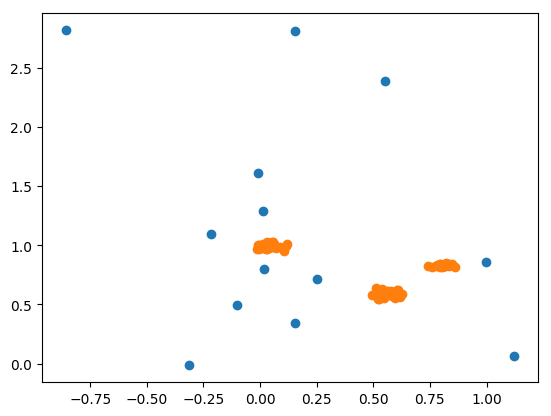

In [3]:
figure()
X = dataset.data
Y = dataset.labels
scatter(X[1, Y.==1], X[2, Y.==1])
scatter(X[1, Y.==0], X[2, Y.==0])
show()

In [4]:
# import the isolation forest from SKlearn
@sk_import ensemble: IsolationForest

PyObject <class 'sklearn.ensemble.iforest.IsolationForest'>

In [5]:
n_estimators=100  # how many estimators to use
max_samples="auto" # how many samples to draw from X for each estimator
contamination = 0.0 # size(Y[Y.==1],1)/size(Y,1) # to set the decision threshold
max_features=1.0 # how many features to use (if float, then it is a ratio)
bootstrap=false # bootstrapping - if false, sample without replacing
n_jobs=1 # how many cores to use
#random_state=None # seed or generator
verbose=0 # verbosity of the fitting
isoforest = IsolationForest(n_estimators, max_samples, contamination, max_features, bootstrap,
    n_jobs, verbose)

PyObject IsolationForest(bootstrap=False, contamination=0.0, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=0,
        verbose=0)

In [6]:
fit!(isoforest, X[:,Y.==0]')

┌ Warning: The default `strides(a::AbstractArray)` implementation is deprecated for general arrays.
│ Specialize `strides(::LinearAlgebra.Adjoint)` if `LinearAlgebra.Adjoint` indeed uses a strided representation in memory.
│ Warning: inappropriately implementing this method for an array type that does not use strided
│ storage may lead to incorrect results or segfaults.
│   caller = stride at abstractarray.jl:350 [inlined]
└ @ Core ./abstractarray.jl:350
┌ Warning: The default `strides(a::AbstractArray)` implementation is deprecated for general arrays.
│ Specialize `strides(::LinearAlgebra.Adjoint)` if `LinearAlgebra.Adjoint` indeed uses a strided representation in memory.
│ Warning: inappropriately implementing this method for an array type that does not use strided
│ storage may lead to incorrect results or segfaults.
│   caller = stride at abstractarray.jl:350 [inlined]
└ @ Core ./abstractarray.jl:350


PyObject IsolationForest(bootstrap=False, contamination=0.0, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=0,
        verbose=0)

In [7]:
import ScikitLearn: decision_function

In [8]:
decision_function(isoforest, X')[:]

103-element Array{Float64,1}:
  0.05634439132780816 
  0.06474626369514674 
  0.07077681758270954 
 -0.03827968014569716 
 -0.08316360191635142 
  0.011229009158983339
  0.0230698021174221  
  0.07149483922317379 
  0.052676853358020914
  0.06790088060485777 
  0.07717991917027317 
 -0.019289528673766543
 -0.0339992995207421  
  ⋮                   
 -0.0479484748186666  
 -0.0909000446152537  
 -0.09861527401179582 
 -0.09809741181205278 
 -0.08723221783726509 
 -0.12624826777412712 
 -0.12624826777412712 
 -0.08734231200824949 
 -0.11183521522307904 
 -0.07222661649681583 
 -0.09784382377259049 
 -0.0909000446152537  

In [9]:
tsthat = AnomalyDetection.labels2bin(predict(isoforest, dataset.data'))

103-element Array{Int64,1}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 0
 0
 1
 1
 1
 1
 1

In [10]:
# anomaly score contour plot
# get limits of the figure
xl = (minimum(X[1,:])-0.05, maximum(X[1,:]) + 0.05)
yl = (minimum(X[2,:])-0.05, maximum(X[2,:]) + 0.05)

# compute the anomaly score on a grid
x = range(xl[1], stop=xl[2], length=30)
y = range(yl[1], stop=yl[2], length=30)
zz = zeros(size(y,1),size(x,1))
for i in 1:size(y, 1)
    for j in 1:size(x, 1)
        zz[i,j] = ScikitLearn.decision_function(isoforest, [x[j], y[i]]')[1]
    end
end

┌ Warning: The default `strides(a::AbstractArray)` implementation is deprecated for general arrays.
│ Specialize `strides(::LinearAlgebra.Adjoint)` if `LinearAlgebra.Adjoint` indeed uses a strided representation in memory.
│ Warning: inappropriately implementing this method for an array type that does not use strided
│ storage may lead to incorrect results or segfaults.
│   caller = stride at abstractarray.jl:350 [inlined]
└ @ Core ./abstractarray.jl:350
┌ Warning: The default `strides(a::AbstractArray)` implementation is deprecated for general arrays.
│ Specialize `strides(::LinearAlgebra.Adjoint)` if `LinearAlgebra.Adjoint` indeed uses a strided representation in memory.
│ Warning: inappropriately implementing this method for an array type that does not use strided
│ storage may lead to incorrect results or segfaults.
│   caller = stride at abstractarray.jl:350 [inlined]
└ @ Core ./abstractarray.jl:350


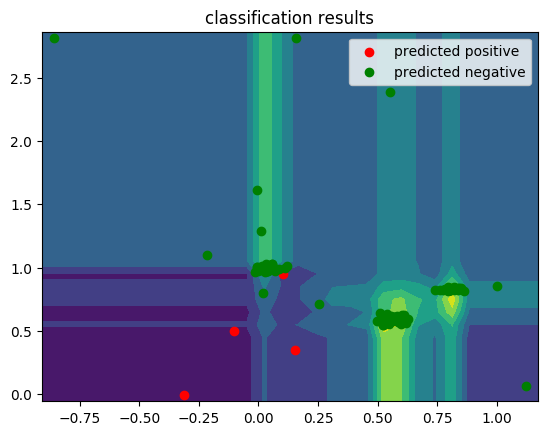

In [11]:
# plot it all
f = figure()
contourf(x, y, zz)
scatter(X[1, tsthat.==0], X[2, tsthat.==0], c = "r", 
    label = "predicted positive")
scatter(X[1, tsthat.==1], X[2, tsthat.==1], c = "g", 
    label = "predicted negative")
title("classification results")
xlim(xl)
ylim(yl)
legend()
show()


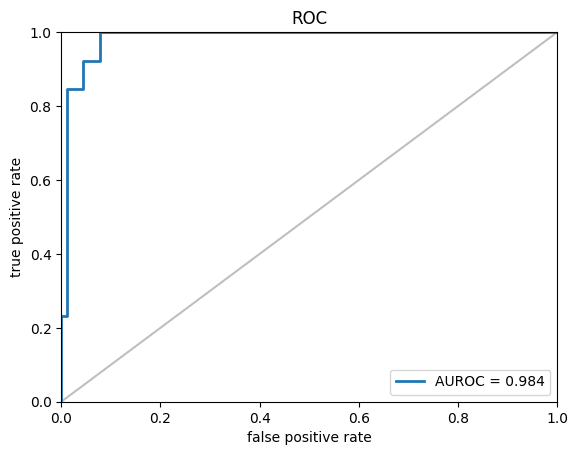

In [12]:
# plot ROC curve and compute AUROC score
ascore = 1.0.-decision_function(isoforest, X')[:]
fprvec, tprvec = EvalCurves.roccurve(ascore, Y)
auroc = round(EvalCurves.auc(fprvec, tprvec),digits=3)
EvalCurves.plotroc((fprvec, tprvec, "AUROC = $(auroc)"))
show()